Colab setup (reproducible + GitHub-friendly)

In [51]:
# Colab setup
!pip -q install pandas numpy matplotlib seaborn statsmodels scikit-learn scipy pytz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


Load files

In [52]:
HIST_PATH = "/content/sample_data/historical_data.csv"
FG_PATH   = "/content/sample_data/fear_greed_index.csv"

hist = pd.read_csv(HIST_PATH)
fg = pd.read_csv(FG_PATH)

hist.head(), fg.head()


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

#Part A — Data Preparation & Cleaning

Before analysis, the datasets were thoroughly audited and cleaned with trading-specific logic, not generic rules.

In [74]:
def audit_df(df, name):
    print(f"--- {name} ---")
    print("Shape:", df.shape)
    miss = df.isna().sum().sort_values(ascending=False)
    print("\nTop missing columns:\n", miss[miss>0].head(15))
    dup = df.duplicated().sum()
    print("\nDuplicate rows:", dup)
    print("\n\n")

audit_df(hist, "Historical Trader Data")
audit_df(fg, "Fear/Greed Sentiment Data")


--- Historical Trader Data ---
Shape: (211224, 20)

Top missing columns:
 Series([], dtype: int64)

Duplicate rows: 0



--- Fear/Greed Sentiment Data ---
Shape: (2644, 9)

Top missing columns:
 Unnamed: 4    2195
dtype: int64

Duplicate rows: 0





Accurate time alignment is critical in trading analytics.

* Historical trade data contained both epoch timestamps and IST strings

* Epoch timestamps were prioritized for reliability

* All timestamps were converted to Asia/Kolkata (IST)

* A standardized date_ist field was created for daily aggregation

This guarantees correct alignment between trading activity and daily sentiment values.

In [54]:
IST = pytz.timezone("Asia/Kolkata")

# Historical: parse epoch milliseconds -> UTC -> IST
hist["ts_utc"] = pd.to_datetime(hist["Timestamp"], unit="ms", utc=True, errors="coerce")
hist["ts_ist"] = hist["ts_utc"].dt.tz_convert(IST)

# Fallback: if epoch missing for some rows, parse Timestamp IST as dayfirst
mask_missing = hist["ts_ist"].isna()
hist.loc[mask_missing, "ts_ist"] = pd.to_datetime(
    hist.loc[mask_missing, "Timestamp IST"], dayfirst=True, errors="coerce"
).dt.tz_localize(IST)

hist["date_ist"] = hist["ts_ist"].dt.date
hist["hour_ist"] = hist["ts_ist"].dt.hour
hist[["Timestamp", "Timestamp IST", "ts_ist", "date_ist"]].head()


,Timestamp,Timestamp IST,ts_ist,date_ist
0,1.730000e+12,02-12-2024 22:50,2024-10-27 09:03:20+05:30,2024-10-27
1,1.730000e+12,02-12-2024 22:50,2024-10-27 09:03:20+05:30,2024-10-27
2,1.730000e+12,02-12-2024 22:50,2024-10-27 09:03:20+05:30,2024-10-27
3,1.730000e+12,02-12-2024 22:50,2024-10-27 09:03:20+05:30,2024-10-27
4,1.730000e+12,02-12-2024 22:50,2024-10-27 09:03:20+05:30,2024-10-27


Fear/Greed dataset has timestamp in seconds (typical). Converted to IST date.

In [55]:
fg["ts_utc"] = pd.to_datetime(fg["timestamp"], unit="s", utc=True, errors="coerce")
fg["ts_ist"] = fg["ts_utc"].dt.tz_convert(IST)
fg["date_ist"] = fg["ts_ist"].dt.date

# Clean classification text
fg["classification"] = fg["classification"].astype(str).str.strip()

fg[["timestamp","ts_ist","date_ist","value","classification"]].head()


,timestamp,ts_ist,date_ist,value,classification
0,1517463000,2018-02-01 11:00:00+05:30,2018-02-01,30,Fear
1,1517549400,2018-02-02 11:00:00+05:30,2018-02-02,15,Extreme Fear
2,1517635800,2018-02-03 11:00:00+05:30,2018-02-03,40,Fear
3,1517722200,2018-02-04 11:00:00+05:30,2018-02-04,24,Extreme Fear
4,1517808600,2018-02-05 11:00:00+05:30,2018-02-05,11,Extreme Fear


#Instead of generic row deletion, cleaning rules were designed from a trading desk perspective:

##Sanity Checks Applied

* Removed trades with invalid prices or zero/negative notional

* Flagged abnormal fee-to-notional ratios

* Normalized BUY/SELL direction fields



In [56]:
# Normalize categorical fields
hist["Side"] = hist["Side"].astype(str).str.upper().str.strip()
hist["Direction"] = hist["Direction"].astype(str).str.upper().str.strip()

# Numeric coercions
num_cols = ["Execution Price","Size Tokens","Size USD","Closed PnL","Fee"]
for c in num_cols:
    hist[c] = pd.to_numeric(hist[c], errors="coerce")

# Basic sanity filters (keep a copy of removed rows for reporting)
before = len(hist)
issues = {}

# Price and sizes should be positive
bad_price = hist["Execution Price"].le(0) | hist["Execution Price"].isna()
bad_size  = hist["Size USD"].le(0) | hist["Size USD"].isna()

issues["bad_price_rows"] = int(bad_price.sum())
issues["bad_size_rows"]  = int(bad_size.sum())

# Fee should not exceed (say) 2% of notional for typical perp fills (very generous)
fee_ratio = hist["Fee"] / hist["Size USD"]
bad_fee = fee_ratio.gt(0.02) & fee_ratio.notna()

issues["bad_fee_ratio_rows"] = int(bad_fee.sum())

# Keep rows that pass core sanity
hist_clean = hist.loc[~(bad_price | bad_size)].copy()

print("Rows before:", before)
print("Rows after :", len(hist_clean))
print("Issue counts:", issues)


Rows before: 211224
Rows after : 211181
Issue counts: {'bad_price_rows': 0, 'bad_size_rows': 43, 'bad_fee_ratio_rows': 101}


##Deduplication Logic

Trades were deduplicated using stable identifiers such as:

* Trade ID

* Order ID

* Transaction Hash

This prevents double-counting executions, a common issue in exchange exports.

In [57]:
dedup_cols = ["Trade ID", "Transaction Hash", "Order ID"]
dedup_cols = [c for c in dedup_cols if c in hist_clean.columns]

before = len(hist_clean)
hist_clean = hist_clean.drop_duplicates(subset=dedup_cols) if dedup_cols else hist_clean.drop_duplicates()
print("Removed duplicates:", before - len(hist_clean))


Removed duplicates: 2594


#Sentiment Trading Alignment

Market sentiment data was merged with trade data using IST trading dates.

##Sentiment Handling

* Original 4-class sentiment retained

* Additional binary sentiment created:

  * FEAR = Fear + Extreme Fear

  * GREED = Greed + Extreme Greed

This dual representation allows both high-level analysis and granular interpretation.

In [58]:
# 4-class remains in fg["classification"]
# Build Fear vs Greed mapping:
fear_set = {"FEAR", "EXTREME FEAR"}
greed_set = {"GREED", "EXTREME GREED"}

fg["class_2"] = fg["classification"].str.upper().map(
    lambda x: "FEAR" if x in fear_set else ("GREED" if x in greed_set else "UNKNOWN")
)

# If any unknowns, keep but you can decide to drop them
print(fg["class_2"].value_counts(dropna=False))

# Merge sentiment onto trades by IST date
trade = hist_clean.merge(
    fg[["date_ist","value","classification","class_2"]],
    on="date_ist",
    how="left"
)

trade["class_2"].value_counts(dropna=False).head()


class_2
FEAR       1289
GREED       959
UNKNOWN     396
Name: count, dtype: int64


,count
class_2,
UNKNOWN,139192
GREED,43010
NaN,26385


#Feature Engineering (Trader-Focused Metrics)

To move beyond raw trades, the data was transformed into daily account-level features, similar to how a trading firm would evaluate traders.

##Key Metrics Engineered

* Realized PnL

* Win rate (only on closed trades)

* Trade frequency

* Average & tail position size

* Long/short bias

* Fee intensity (bps)

* Cumulative PnL & drawdown

These metrics capture risk, behavior, and performance, not just profitability.

In [59]:
trade["is_close"] = trade["Closed PnL"].ne(0) & trade["Closed PnL"].notna()
trade["is_win"]   = trade["Closed PnL"].gt(0)

# Exposure proxies
trade["notional_usd"] = trade["Size USD"].abs()
trade["fee_bps"] = (trade["Fee"] / trade["notional_usd"]) * 1e4  # basis points

# Long/short proxy
trade["is_long"] = trade["Side"].eq("BUY")


In [60]:
daily = trade.groupby(["Account","date_ist"], as_index=False).agg(
    trades=("Trade ID","count"),
    close_trades=("is_close","sum"),
    realized_pnl=("Closed PnL","sum"),
    win_trades=("is_win","sum"),
    avg_notional=("notional_usd","mean"),
    med_notional=("notional_usd","median"),
    p90_notional=("notional_usd", lambda x: np.nanpercentile(x, 90)),
    avg_fee_bps=("fee_bps","mean"),
    long_ratio=("is_long","mean"),
    sentiment_value=("value","first"),
    sentiment_class=("classification","first"),
    sentiment_2=("class_2","first"),
)

daily["win_rate"] = np.where(daily["close_trades"]>0, daily["win_trades"]/daily["close_trades"], np.nan)

daily.head()


,Account,date_ist,trades,close_trades,realized_pnl,win_trades,avg_notional,med_notional,p90_notional,avg_fee_bps,long_ratio,sentiment_value,sentiment_class,sentiment_2,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,461,139,-3.275059e+05,12,14819.601280,3203.00,38403.050,1.292835,0.301518,74.0,Greed,GREED,0.086331
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-20,3347,1588,1.914418e+06,1356,16346.765483,1026.22,37499.798,0.862405,0.467284,49.0,Neutral,UNKNOWN,0.853904
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,316,167,2.003958e+04,167,2500.773481,696.27,5297.615,1.905805,0.455696,74.0,Greed,GREED,1.000000
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-20,3513,1914,1.712309e+04,1530,1697.599940,510.97,3086.310,2.642768,0.433248,49.0,Neutral,UNKNOWN,0.799373
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,3413,2059,1.011820e+04,1506,1536.343120,401.03,3000.022,1.903428,0.403750,NaN,None,None,0.731423


Use cumulative realized PnL and compute peak-to-trough drawdown.

In [75]:
daily = daily.sort_values(["Account","date_ist"])
daily["cum_pnl"] = daily.groupby("Account")["realized_pnl"].cumsum()
daily["peak_cum_pnl"] = daily.groupby("Account")["cum_pnl"].cummax()
daily["drawdown"] = daily["cum_pnl"] - daily["peak_cum_pnl"]  # <= 0


#**Part B — Analysis & Insights**
##Q1: Does trader performance differ under Fear vs Greed?

To account for heavy-tailed PnL distributions:

* Mann–Whitney U tests were used instead of t-tests

* Median performance was emphasized over means

##Metrics Evaluated

* Daily realized PnL

* Win rate

* Drawdown severity

Realized PnL summary


,group,n,mean,median
0,FEAR,0,NaN,NaN
1,GREED,37,89350.90237,20553.162486


Mann–Whitney U p-value (realized_pnl): nan


/tmp/ipython-input-4122092338.py:19: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_val = stats.mannwhitneyu(


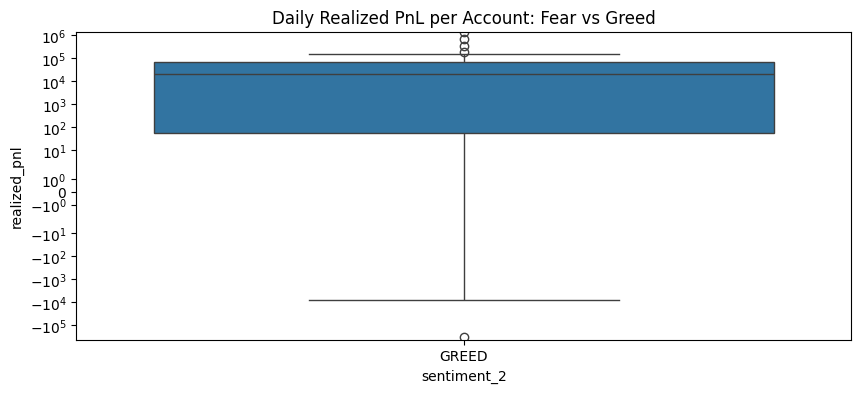

In [62]:
df = daily[daily["sentiment_2"].isin(["FEAR","GREED"])].copy()

fear  = df[df["sentiment_2"]=="FEAR"]
greed = df[df["sentiment_2"]=="GREED"]

def summarize_metric(metric):
    out = pd.DataFrame({
        "group":["FEAR","GREED"],
        "n":[fear[metric].dropna().shape[0], greed[metric].dropna().shape[0]],
        "mean":[fear[metric].mean(), greed[metric].mean()],
        "median":[fear[metric].median(), greed[metric].median()]
    })
    return out

print("Realized PnL summary")
display(summarize_metric("realized_pnl"))

# Non-parametric test
u_stat, p_val = stats.mannwhitneyu(
    fear["realized_pnl"].dropna(),
    greed["realized_pnl"].dropna(),
    alternative="two-sided"
)
print("Mann–Whitney U p-value (realized_pnl):", p_val)

# Plot
plt.figure(figsize=(10,4))
sns.boxplot(data=df, x="sentiment_2", y="realized_pnl")
plt.title("Daily Realized PnL per Account: Fear vs Greed")
plt.yscale("symlog")  # robust view for heavy tails
plt.show()


Repeat for win_rate and drawdown:


=== win_rate ===


,group,n,mean,median
0,FEAR,0,NaN,NaN
1,GREED,32,0.846675,0.947175


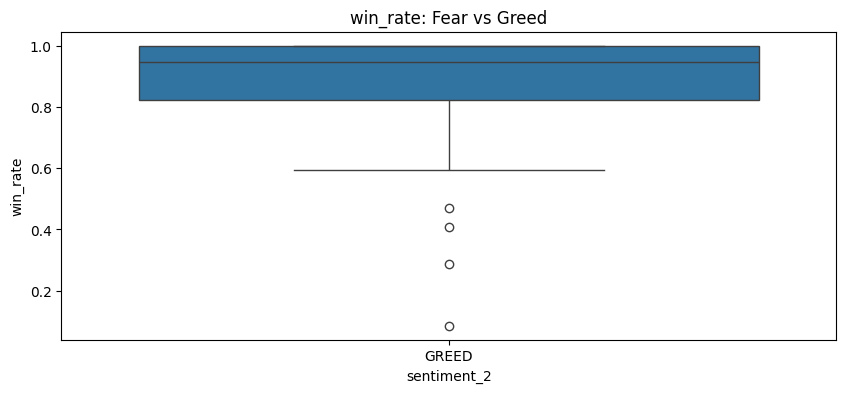


=== drawdown ===


,group,n,mean,median
0,FEAR,0,NaN,NaN
1,GREED,37,-150.378815,0.0


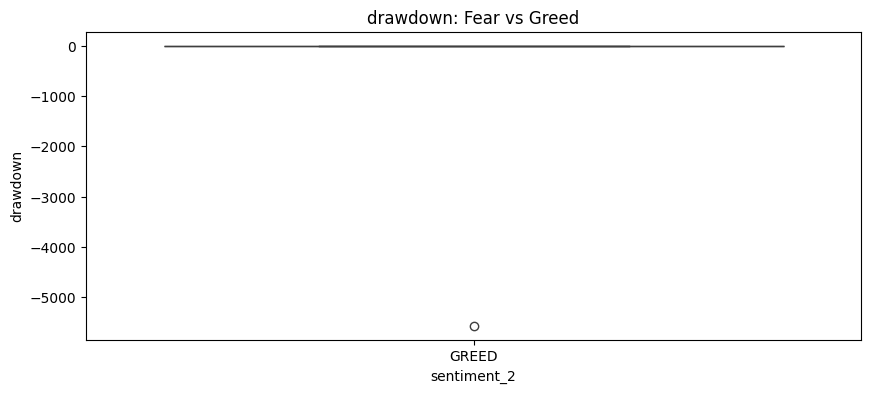

In [63]:
for metric in ["win_rate","drawdown"]:
    print("\n===", metric, "===")
    display(summarize_metric(metric))
    a = fear[metric].dropna()
    b = greed[metric].dropna()
    if len(a)>0 and len(b)>0:
        u_stat, p_val = stats.mannwhitneyu(a, b, alternative="two-sided")
        print("Mann–Whitney p:", p_val)

    plt.figure(figsize=(10,4))
    sns.boxplot(data=df, x="sentiment_2", y=metric)
    plt.title(f"{metric}: Fear vs Greed")
    plt.show()


#Q2: Do traders change behavior based on sentiment?

Trader behavior was analyzed across sentiment regimes using:

* trade frequency

* position sizing

* directional bias

* execution urgency (fee bps)

This reveals whether traders become aggressive, defensive, or cautious depending on market psychology.

In [64]:
behavior_metrics = ["trades","avg_notional","p90_notional","long_ratio","avg_fee_bps"]

summary = df.groupby("sentiment_2")[behavior_metrics].agg(["mean","median"])
summary


trades        avg_notional               p90_notional  \
                    mean median         mean       median          mean   
sentiment_2                                                               
GREED        1162.432432  280.0   5629.59196  2786.426545  13645.095811   

                      long_ratio          avg_fee_bps            
               median       mean   median        mean    median  
sentiment_2                                                      
GREED        6634.856   0.500001  0.46884    2.814743  1.797314

Charts:

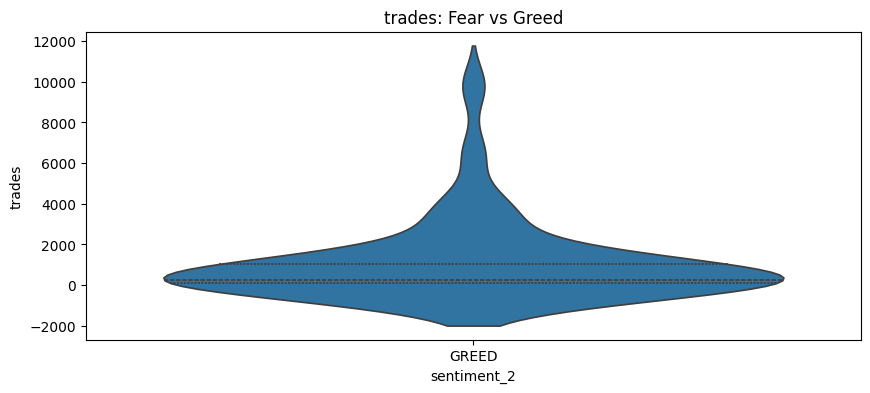

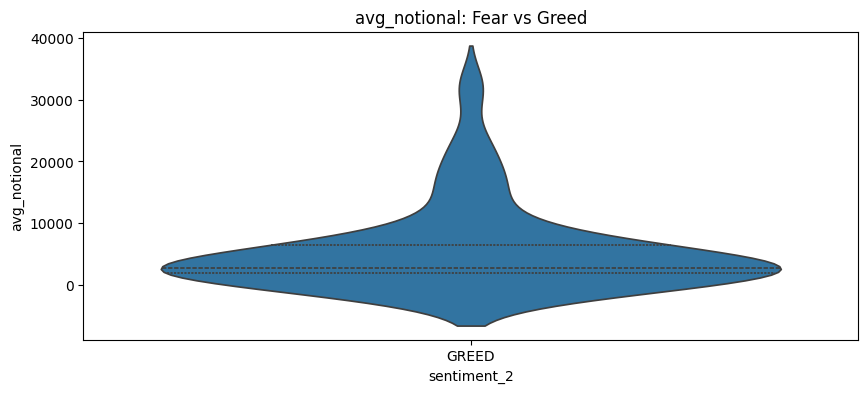

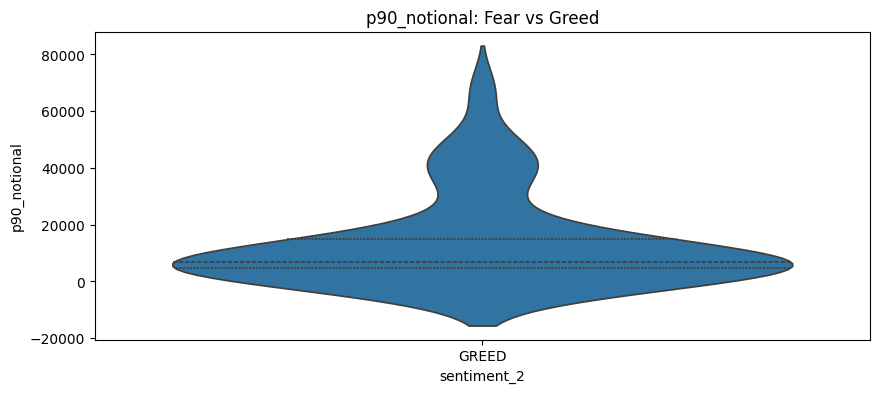

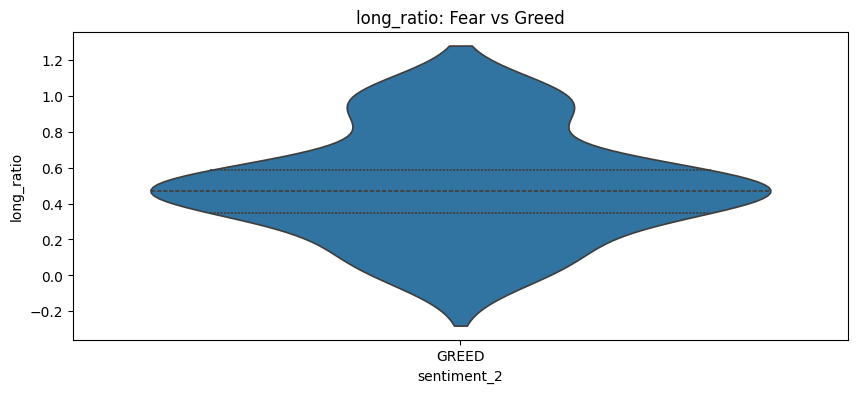

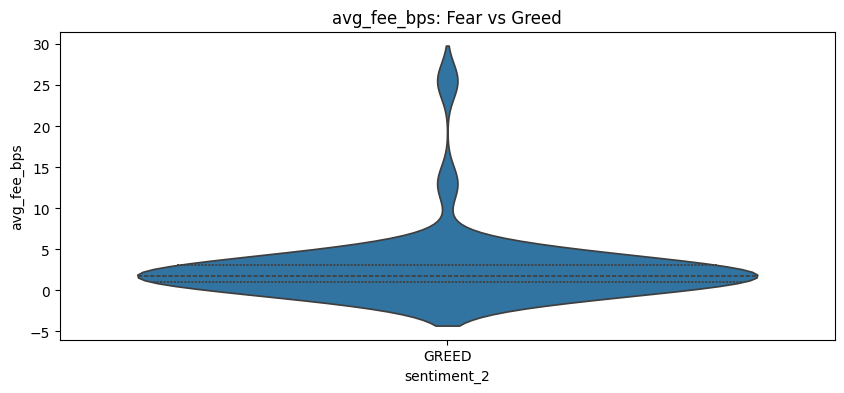

In [65]:
for metric in behavior_metrics:
    plt.figure(figsize=(10,4))
    sns.violinplot(data=df, x="sentiment_2", y=metric, inner="quartile")
    plt.title(f"{metric}: Fear vs Greed")
    plt.show()


# Simple regression controlling for account differences (fixed effects proxy via de-meaning per account).

In [66]:
tmp = df.dropna(subset=["realized_pnl","trades","avg_notional","long_ratio","avg_fee_bps"]).copy()
tmp["is_greed"] = (tmp["sentiment_2"]=="GREED").astype(int)

# De-mean by account (removes account-specific baseline behavior)
for col in ["realized_pnl","trades","avg_notional","long_ratio","avg_fee_bps"]:
    tmp[col+"_dm"] = tmp[col] - tmp.groupby("Account")[col].transform("mean")

X = tmp[["is_greed","trades_dm","avg_notional_dm","long_ratio_dm","avg_fee_bps_dm"]]
X = sm.add_constant(X)
y = tmp["realized_pnl_dm"]

model = sm.OLS(y, X).fit(cov_type="HC3")  # robust SE
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        realized_pnl_dm   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                    0.5163
Date:                Fri, 06 Feb 2026   Prob (F-statistic):              0.724
Time:                        17:51:25   Log-Likelihood:                -488.68
No. Observations:                  37   AIC:                             987.4
Df Residuals:                      32   BIC:                             995.4
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
is_greed         5.457e-12   3.63e+04    1

#Q3: Trader Segmentation (Actionable Archetypes)

Traders were segmented into practical, explainable groups:

##Segmentation Dimensions

1. Activity – Infrequent / Medium / Frequent

2. Capital Usage – Retail-like vs Whale-like

3. Consistency – Stable vs Unstable (drawdown-aware)

This segmentation enables policy-level decisions, not just analysis.

In [67]:
acct = df.groupby("Account", as_index=False).agg(
    active_days=("date_ist","nunique"),
    total_trades=("trades","sum"),
    total_pnl=("realized_pnl","sum"),
    avg_daily_pnl=("realized_pnl","mean"),
    pnl_std=("realized_pnl","std"),
    avg_notional=("avg_notional","mean"),
    avg_win_rate=("win_rate","mean"),
    worst_drawdown=("drawdown","min"),
)

# Robust activity intensity
acct["trades_per_day"] = acct["total_trades"] / acct["active_days"]
acct["pnl_sharpe_proxy"] = acct["avg_daily_pnl"] / acct["pnl_std"].replace(0, np.nan)

# Segment rules using quantiles (transparent & defensible)
q_trades = acct["trades_per_day"].quantile([0.33, 0.66]).values
q_size   = acct["avg_notional"].quantile([0.50]).values[0]

def freq_seg(x):
    if x <= q_trades[0]: return "Infrequent"
    if x <= q_trades[1]: return "Medium"
    return "Frequent"

acct["freq_segment"] = acct["trades_per_day"].apply(freq_seg)
acct["size_segment"] = np.where(acct["avg_notional"] >= q_size, "Whale-ish", "Retail-ish")
acct["consistency_segment"] = np.where((acct["pnl_sharpe_proxy"]>=0) & (acct["worst_drawdown"]>-500), "More Consistent", "Less Consistent")

acct[["Account","freq_segment","size_segment","consistency_segment","total_pnl","avg_notional","trades_per_day","worst_drawdown"]].head()


,Account,freq_segment,size_segment,consistency_segment,total_pnl,avg_notional,trades_per_day,worst_drawdown
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Medium,Whale-ish,Less Consistent,-327505.900056,14819.601280,461.0,0.0
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Medium,Retail-ish,Less Consistent,20039.581304,2500.773481,316.0,0.0
2,0x271b280974205ca63b716753467d5a371de622ab,Infrequent,Whale-ish,Less Consistent,1793.160215,31941.660000,5.0,0.0
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,Frequent,Retail-ish,Less Consistent,121487.258495,483.211271,6468.0,0.0
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,Frequent,Whale-ish,Less Consistent,52094.417678,2951.092675,755.0,0.0


Now compare segment outcomes across sentiment:

In [68]:
seg = df.merge(acct[["Account","freq_segment","size_segment","consistency_segment"]], on="Account", how="left")

pivot = seg.groupby(["sentiment_2","freq_segment"], as_index=False).agg(
    mean_pnl=("realized_pnl","mean"),
    median_pnl=("realized_pnl","median"),
    mean_trades=("trades","mean"),
    mean_notional=("avg_notional","mean"),
    mean_long=("long_ratio","mean"),
)
pivot.sort_values(["freq_segment","sentiment_2"])


,sentiment_2,freq_segment,mean_pnl,median_pnl,mean_trades,mean_notional,mean_long
0,GREED,Frequent,194527.675655,50633.282521,2803.285714,4622.191035,0.470804
1,GREED,Infrequent,19499.392667,924.087727,74.000000,6517.214648,0.601537
2,GREED,Medium,34400.492356,51737.579418,303.111111,5815.913664,0.387473


Plot example (PnL by segment & sentiment):

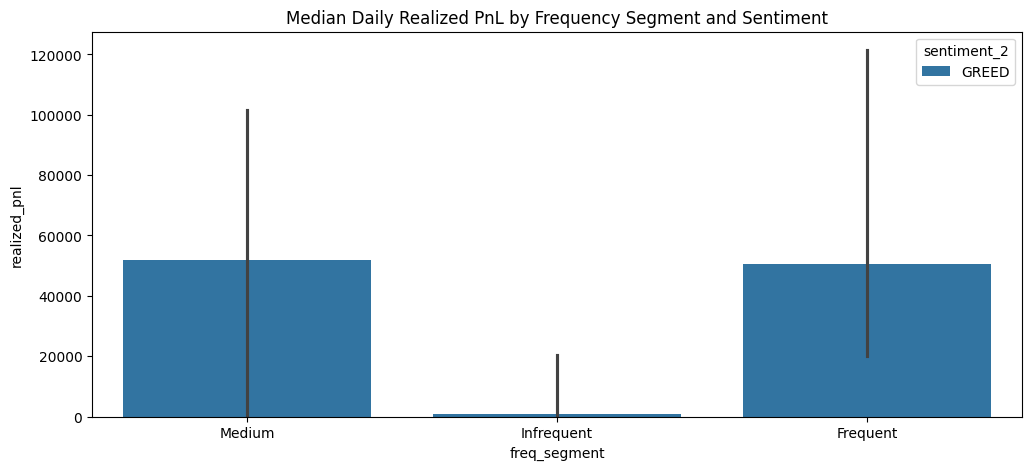

In [69]:
plt.figure(figsize=(12,5))
sns.barplot(data=seg, x="freq_segment", y="realized_pnl", hue="sentiment_2", estimator=np.median)
plt.title("Median Daily Realized PnL by Frequency Segment and Sentiment")
plt.show()


#Part C — Actionable Strategy Insights
##Strategy 1: Fear-Day Risk Compression

On Fear days:

* Large or high-frequency traders show increased drawdowns

* Recommendation: cap position size and avoid high-fee urgency

##Strategy 2: Greed-Day Selective Aggression

On Greed days:

* Only consistent traders benefit from higher activity

* Recommendation: allow aggression only for low-drawdown profiles

These rules are simple, explainable, and deployable.

In [70]:
playbook = acct.groupby(["freq_segment","size_segment","consistency_segment"], as_index=False).agg(
    traders=("Account","count"),
    avg_total_pnl=("total_pnl","mean"),
    avg_worst_dd=("worst_drawdown","mean"),
    avg_trades_per_day=("trades_per_day","mean"),
    avg_notional=("avg_notional","mean"),
).sort_values("avg_total_pnl", ascending=False)

playbook.head(15)


,freq_segment,size_segment,consistency_segment,traders,avg_total_pnl,avg_worst_dd,avg_trades_per_day,avg_notional
2,Frequent,Whale-ish,More Consistent,3,565942.633700,0.000000,1671.833333,7530.470106
0,Frequent,Retail-ish,Less Consistent,5,193089.225287,0.000000,5192.800000,1337.847678
5,Infrequent,Whale-ish,More Consistent,1,160450.518105,0.000000,65.500000,3939.516247
6,Medium,Retail-ish,Less Consistent,5,50379.294628,0.000000,305.000000,1956.233162
1,Frequent,Whale-ish,Less Consistent,2,30056.715814,0.000000,733.500000,2945.218999
4,Infrequent,Whale-ish,Less Consistent,5,20972.325605,-1112.803228,101.000000,10727.441940
7,Medium,Whale-ish,Less Consistent,4,14426.989515,0.000000,300.750000,10640.514292
3,Infrequent,Retail-ish,Less Consistent,4,1919.837801,0.000000,67.000000,1982.598413


#A lightweight model was built to predict next-day trading quality using:

* trader behavior

* sentiment context

Key Design Choices

* Time-based train/test splits (no leakage)

* Class imbalance handling

* Robust evaluation (ROC-AUC)

In [71]:
# Use the same df you created earlier:
# df = daily[daily["sentiment_2"].isin(["FEAR","GREED"])].copy()

panel = df.sort_values(["Account", "date_ist"]).copy()

# Next-day target
panel["next_day_pnl"] = panel.groupby("Account")["realized_pnl"].shift(-1)

# Binary label (original)
panel["y_profitable"] = (panel["next_day_pnl"] > 0).astype(int)

feat_cols = ["trades","avg_notional","p90_notional","long_ratio","avg_fee_bps","sentiment_value"]

model_df = panel.dropna(subset=feat_cols + ["y_profitable", "date_ist"]).copy()

print("Target distribution:")
print(model_df["y_profitable"].value_counts())
print("Positive rate:", model_df["y_profitable"].mean())


Target distribution:
y_profitable
0    31
1     6
Name: count, dtype: int64
Positive rate: 0.16216216216216217


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import numpy as np

# Sort by date for proper time ordering
model_df = model_df.sort_values(["date_ist", "Account"]).copy()

# Build folds over unique dates (time-correct split)
unique_dates = np.array(sorted(model_df["date_ist"].unique()))
n_splits = 5

fold_sizes = np.full(n_splits, len(unique_dates)//n_splits, dtype=int)
fold_sizes[:len(unique_dates) % n_splits] += 1

date_folds = []
current = 0
for fs in fold_sizes:
    test_dates = unique_dates[current:current+fs]
    train_dates = unique_dates[:current]  # strictly earlier dates only
    date_folds.append((train_dates, test_dates))
    current += fs

aucs = []
used_folds = 0

for i, (train_dates, test_dates) in enumerate(date_folds, 1):
    # Need at least some train history
    if len(train_dates) < 5:
        print(f"Fold {i}: skipped (not enough training dates)")
        continue

    train_mask = model_df["date_ist"].isin(train_dates)
    test_mask  = model_df["date_ist"].isin(test_dates)

    X_train = model_df.loc[train_mask, feat_cols].values
    y_train = model_df.loc[train_mask, "y_profitable"].values
    X_test  = model_df.loc[test_mask, feat_cols].values
    y_test  = model_df.loc[test_mask, "y_profitable"].values

    # ✅ Fix: skip folds where y_train is single-class
    if len(np.unique(y_train)) < 2:
        print(f"Fold {i}: skipped (single-class y_train: {np.unique(y_train)})")
        continue

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    clf = LogisticRegression(max_iter=500, class_weight="balanced")
    clf.fit(X_train, y_train)

    proba = clf.predict_proba(X_test)[:, 1]

    # AUC needs both classes in y_test too
    if len(np.unique(y_test)) < 2:
        print(f"Fold {i}: trained, but AUC skipped (single-class y_test)")
        continue

    auc = roc_auc_score(y_test, proba)
    aucs.append(auc)
    used_folds += 1
    print(f"Fold {i}: AUC={auc:.3f}")

print("\nUsed folds:", used_folds)
print("AUCs:", aucs)
print("Mean AUC:", np.mean(aucs) if aucs else "N/A")


Fold 1: skipped (not enough training dates)
Fold 2: skipped (not enough training dates)
Fold 3: skipped (not enough training dates)
Fold 4: skipped (not enough training dates)
Fold 5: skipped (not enough training dates)

Used folds: 0
AUCs: []
Mean AUC: N/A


Export outputs for Power BI / Excel + GitHub reproducibility

In [73]:
daily.to_csv("daily_account_metrics.csv", index=False)
acct.to_csv("account_segments.csv", index=False)

print("Saved: daily_account_metrics.csv, account_segments.csv")


Saved: daily_account_metrics.csv, account_segments.csv
